# This notebook selects culvert-like USGS gages for validation of the delineation model
##### Author: Omid Emamjomehzadeh (https://www.omidemam.com/)
##### Supervisor: Dr. Omar Wani (https://engineering.nyu.edu/faculty/omar-wani)
##### Hydrologic Systems Group @NYU (https://www.omarwani.com/)

In [2]:
# Import libraries
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os
import time
import requests
import pandas as pd
import requests
import os
import time
import rasterio
from rasterio.merge import merge as wtb_mosaic
from osgeo import gdal
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from matplotlib_scalebar.scalebar import ScaleBar
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal


In [3]:
import warnings
# Suppress the specific RuntimeWarning
warnings.filterwarnings("ignore")
# Suppress all UserWarnings, including PerformanceWarnings
warnings.simplefilter('ignore', category=UserWarning)
# plot with Arial font
plt.rcParams['font.family'] = 'Arial'

#### Read the USGS discharge stations' inventory in the NYS

In [2]:
# Define the path to the inventory
file_path = r"D:\culvert repo\data\USGS\inventory.txt"
# Read the file 
with open(file_path, 'r') as file:
    lines = file.readlines()

# Find the start of the data (skip metadata lines)
for i, line in enumerate(lines):
    if line.startswith('agency_cd'):
        header_line = i
        break
# Read the data into a DataFrame
gages = pd.read_csv(file_path, delimiter='\t', skiprows=header_line)
gages = gages.drop(gages.index[0]) #remove the first row
gages.reset_index(drop=True, inplace=True) # reset the index
# Let's assume that there is a culvert in place of the station so remane the site_no to BIN
gages = gages.rename(columns={'site_no': 'BIN'})
# Print
print (gages.shape)
gages.head()

(1486, 56)


,agency_cd,BIN,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,peak_count_nu,qw_begin_date,qw_end_date,qw_count_nu,gw_begin_date,gw_end_date,gw_count_nu,sv_begin_date,sv_end_date,sv_count_nu
0,USGS,01199360,SAWMILL BROOK AT IRONDALE NY,ST,415807,0733130,41.96870339,-73.52456830,M,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USGS,01199477,STONY BK NR DOVER PLAINS NY,ST,414238.7,0733716.9,41.71075000,-73.62136110,N,1,...,47,--,--,0,--,--,0,1990-04-02,2023-08-15,22
2,USGS,0119947805,DOCTORS BROOK AT MOUTH NEAR DOVER FURNACE NY,ST,414154,0733644,41.69842727,-73.61179378,M,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USGS,01209795,TRINITY LAKE RES NR POND RIDGE NY,ST,411252,0733318,41.21453999,-73.55456978,M,S,...,0,1962-04-25,1964-11-24,2,--,--,0,--,--,0
4,USGS,01211310,WAMPUS RIVER NEAR ARMONK NY,ST,410841,0734331,41.14481797,-73.72485350,M,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Create a geodata frame using lat lon columns
gages['geometry'] = gages.apply(lambda x: Point((x['dec_long_va'], x['dec_lat_va'])), axis=1)
gages_geo = gpd.GeoDataFrame(gages, geometry='geometry')
gages_geo.set_crs(epsg=4326, inplace=True)# Set  CRS to WGS84 (EPSG:4326)

,agency_cd,BIN,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,qw_begin_date,qw_end_date,qw_count_nu,gw_begin_date,gw_end_date,gw_count_nu,sv_begin_date,sv_end_date,sv_count_nu,geometry
0,USGS,01199360,SAWMILL BROOK AT IRONDALE NY,ST,415807,0733130,41.96870339,-73.52456830,M,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-73.52457 41.9687)
1,USGS,01199477,STONY BK NR DOVER PLAINS NY,ST,414238.7,0733716.9,41.71075000,-73.62136110,N,1,...,--,--,0,--,--,0,1990-04-02,2023-08-15,22,POINT (-73.62136 41.71075)
2,USGS,0119947805,DOCTORS BROOK AT MOUTH NEAR DOVER FURNACE NY,ST,414154,0733644,41.69842727,-73.61179378,M,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-73.61179 41.69843)
3,USGS,01209795,TRINITY LAKE RES NR POND RIDGE NY,ST,411252,0733318,41.21453999,-73.55456978,M,S,...,1962-04-25,1964-11-24,2,--,--,0,--,--,0,POINT (-73.55457 41.21454)
4,USGS,01211310,WAMPUS RIVER NEAR ARMONK NY,ST,410841,0734331,41.14481797,-73.72485350,M,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-73.72485 41.14482)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,USGS,431517077380301,EAST FORK SLATER CK AT VELMA LN NEAR ROCHESTER NY,ST,431516.9,0773803.8,43.25469444,-77.63438889,G,1,...,2018-07-18,2018-07-18,1,--,--,0,--,--,0,POINT (-77.63439 43.25469)
1482,USGS,435908074141801,"Arbutus Pond Box Coring Site B3 nr Newcomb, NY",LK,435907.9,0741418.2,43.98552778,-74.23838889,G,1,...,2007-07-17,2008-06-17,71,--,--,0,--,--,0,POINT (-74.23839 43.98553)
1483,USGS,435919074143301,"Arbutus Pond Box Coring Site B2 nr Newcomb, NY",LK,435919.0,0741433.3,43.98861110,-74.24258330,G,1,...,2007-07-17,2007-07-17,35,--,--,0,--,--,0,POINT (-74.24258 43.98861)
1484,USGS,435929074144301,"Arbutus Pond Box Coring Site B1 nr Newcomb, NY",LK,435928.9,0741442.8,43.99136110,-74.24522220,G,1,...,2007-07-17,2007-07-17,55,--,--,0,--,--,0,POINT (-74.24522 43.99136)


In [4]:
gages_geo['drain_area_va'] = pd.to_numeric(gages_geo['drain_area_va'], errors='coerce')

In [5]:
gages_geo['drain_area_va'].describe()

count    1486.000000
mean        0.939679
std         0.545938
min         0.000000
25%         0.462500
50%         0.910000
75%         1.380000
max         1.990000
Name: drain_area_va, dtype: float64

In [6]:
base_dir=r'D:\culvert repo\data\initial layers'
state_shapefile_path = rf"{base_dir}\state_5070.shp"
stream_shapefile_path = rf"{base_dir}\stream_5070.shp"
stream_highres_shapefile_path = rf"{base_dir}\stream_highres_5070.shp"
road_shapefile_path = rf"{base_dir}\road_5070.shp"
street_shapefile_path = rf"{base_dir}\streets_5070.shp"
railroad_shapefile_path = rf"{base_dir}\railroad_NYS_cliped.shp"
culvert_shapefile_path = rf"{base_dir}\culvert_5070.shp"
HUC12_shapefile_path = rf"{base_dir}\HUC_12_5070.shp"
DEM_path = rf"{base_dir}\NYS_DEM_5070.tif"
bridge_path = rf"{base_dir}\NYSDOT_Bridges.shp"

# Load the HUC12 shapefile
state_shapefile = gpd.read_file(state_shapefile_path)
stream_shapefile= gpd.read_file(stream_shapefile_path)
road_shapefile= gpd.read_file(road_shapefile_path)
HUC12_shapfile=gpd.read_file(HUC12_shapefile_path)

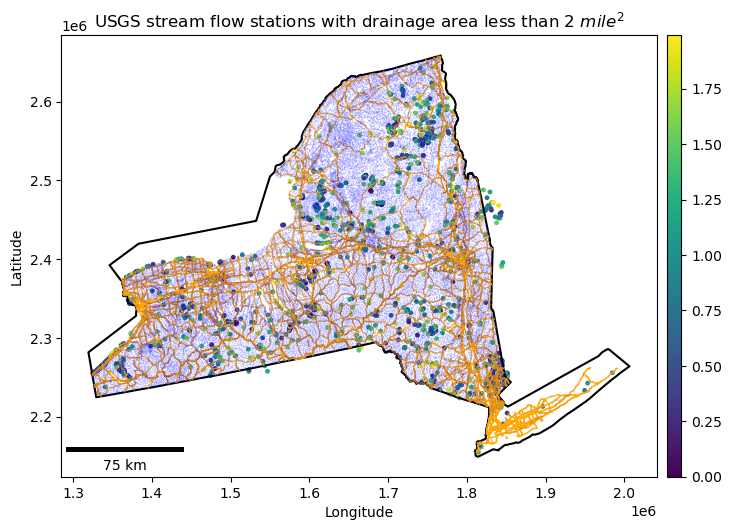

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.pyplot as plt

# Reproject gages to EPSG:5070
gages_geo.to_crs(epsg=5070, inplace=True)

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2.5%", pad=0.1)  

# Plot gages with smaller point size and colorbar
gages_geo.plot(
    column='drain_area_va',
    cmap='viridis',
    legend=True,
    ax=ax,
    cax=cax,
    markersize=6  # Smaller radius
)

# Overlay additional shapefiles
road_shapefile.plot(ax=ax, color='orange', linewidth=1, alpha=0.7)
stream_shapefile.plot(ax=ax, color='blue', linewidth=0.3, alpha=0.3)
state_shapefile.plot(ax=ax, edgecolor='black', linewidth=1.5, facecolor='none')

# Titles and labels
ax.set_title('USGS stream flow stations with drainage area less than 2 $mile^2$')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add scale bar
scalebar = ScaleBar(0.5, units="m", dimension="si-length", location="lower left")
ax.add_artist(scalebar)

# Save and show
plt.savefig(r'D:\culvert repo\Results\Figures\USGS_stations_less2_drainarea.png', dpi=300)
plt.show()


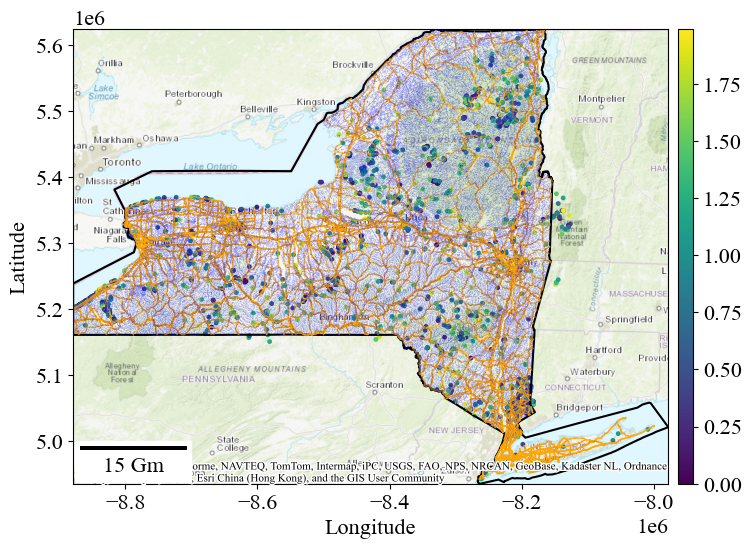

In [11]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import contextily as ctx
import geopandas as gpd
from shapely.geometry import box

# Font setup
plt.rc('font', family='Times New Roman', size=16)

# Set CRS
crs_deg = 'EPSG:4326'
crs_web = 'EPSG:3857'
crs_m = 'EPSG:5070'

# Reproject to 4326 then 3857 for contextily basemap
gages_geo = gages_geo.to_crs(crs_deg).to_crs(crs_web)
road_shapefile = road_shapefile.to_crs(crs_deg).to_crs(crs_web)
stream_shapefile = stream_shapefile.to_crs(crs_deg).to_crs(crs_web)
state_shapefile = state_shapefile.to_crs(crs_deg).to_crs(crs_web)

# Compute bounds and aspect ratio
minx, miny, maxx, maxy = state_shapefile.total_bounds
data_width = maxx - minx
data_height = maxy - miny
aspect_ratio = data_width / data_height
fig_width = 8
fig_height = fig_width / aspect_ratio

# Create figure and axis
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2.5%", pad=0.1)

# Plot gages
gages_geo.plot(
    column='drain_area_va',
    cmap='viridis',
    legend=True,
    ax=ax,
    cax=cax,
    markersize=6
)

# Plot overlays
road_shapefile.plot(ax=ax, color='orange', linewidth=1, alpha=0.7)
stream_shapefile.plot(ax=ax, color='blue', linewidth=0.3, alpha=0.3)
state_shapefile.plot(ax=ax, edgecolor='black', linewidth=1.5, facecolor='none')

# Add basemap
ctx.add_basemap(ax, crs=crs_web, source=ctx.providers.Esri.WorldTopoMap)

# Labels
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#ax.set_title('USGS stream flow stations with drainage area less than 2 $mile^2$')

# Scale bar (calculate from 4326 → 5070)
bbox_geom = box(*gages_geo.to_crs(crs_deg).total_bounds)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox_geom]}, crs=crs_deg)
bbox_5070 = bbox_gdf.to_crs(crs_m)
scale_width_m = bbox_5070.geometry[0].bounds[2] - bbox_5070.geometry[0].bounds[0]
scale_width_deg = bbox_gdf.geometry[0].bounds[2] - bbox_gdf.geometry[0].bounds[0]
meters_per_degree = scale_width_m / scale_width_deg

# Add scale bar
scalebar = ScaleBar(dx=1*meters_per_degree, units="m", dimension="si-length",
                    location="lower left", scale_loc="bottom")
ax.add_artist(scalebar)

# Save and show
plt.savefig(r'D:\culvert repo\Results\Figures\USGS_stations_less2_drainarea_with_basemap.png', dpi=300)
plt.show()


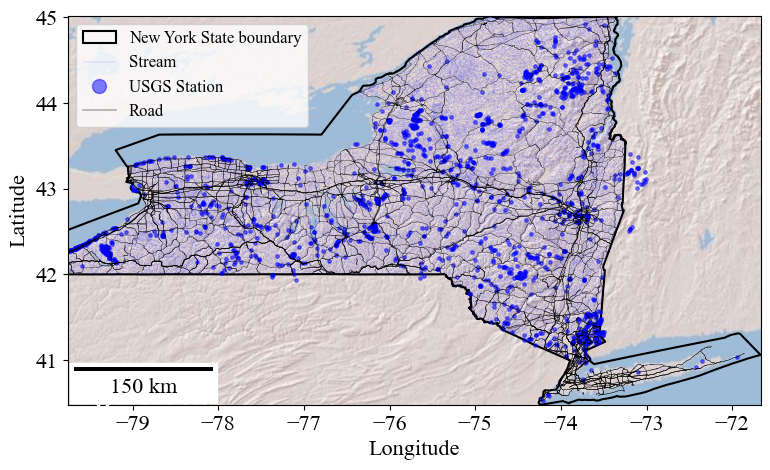

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx
import geopandas as gpd
from shapely.geometry import box

# Font setup
plt.rc('font', family='Times New Roman', size=16)

# Set CRS
crs_deg = 'EPSG:4326'
crs_m = 'EPSG:5070'

# Reproject all data to EPSG:4326
state_shapefile = state_shapefile.to_crs(crs_deg)
stream_shapefile = stream_shapefile.to_crs(crs_deg)
gages_geo = gages_geo.to_crs(crs_deg)
road_shapefile = road_shapefile.to_crs(crs_deg)

# Compute bounds and figure size
minx, miny, maxx, maxy = state_shapefile.total_bounds
data_width = maxx - minx
data_height = maxy - miny
aspect_ratio = data_width / data_height
fig_width = 9
fig_height = fig_width / aspect_ratio

# Create figure and axis
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Plot layers
state_shapefile.plot(ax=ax, edgecolor='black', linewidth=1.5, facecolor='none')
stream_shapefile.plot(ax=ax, color='blue', linewidth=0.1, alpha=0.5)
road_shapefile.plot(ax=ax, color='black', linewidth=0.3, alpha=0.8)
gages_geo.plot(ax=ax, color='blue', markersize=6, alpha=0.5, marker='o', linestyle='None')

# Add basemap (in EPSG:4326)
ctx.add_basemap(ax, crs=state_shapefile.crs, source=ctx.providers.Esri.WorldShadedRelief)

# Legend
legend_handles = [
    mpatches.Patch(edgecolor='black', facecolor='none', linewidth=1.5, label='New York State boundary'),
    Line2D([0], [0], color='blue', lw=0.3, alpha=0.3, label='Stream'),
    Line2D([0], [0], marker='o', color='blue', markersize=10, alpha=0.5, linestyle='None', label='USGS Station'),
    Line2D([0], [0], color='black', lw=1.2, alpha=0.3, label='Road'),
]
ax.legend(handles=legend_handles, loc='upper left', prop={'family': 'Times New Roman', 'size': 12}, frameon=True)

# ----- Add scale bar -----
bbox_geom = box(minx, miny, maxx, maxy)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox_geom]}, crs=crs_deg)
bbox_5070 = bbox_gdf.to_crs(crs_m)
scale_width_m = bbox_5070.geometry[0].bounds[2] - bbox_5070.geometry[0].bounds[0]
scale_width_deg = maxx - minx
meters_per_degree = scale_width_m / scale_width_deg

scalebar = ScaleBar(dx=1*meters_per_degree, units="m", dimension="si-length",
                    location="lower left", scale_loc="bottom")
ax.add_artist(scalebar)
# Save and show
plt.savefig(r'D:\culvert repo\Results\Figures\initial_layers_usgs_roads_with_scale.png', dpi=300)
plt.show()

In [28]:
gages_geo.to_file(r"D:\culvert repo\Results\Validation\watershed\all_validation_points.shp")

C:\Users\Omid Emamjomehzadeh\AppData\Local\Temp\ipykernel_37288\959479733.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gages_geo.to_file(r"D:\culvert repo\Results\Validation\watershed\all_validation_points.shp")
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'dec_long_va' to 'dec_long_v'
  ogr_write(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'coord_meth_cd' to 'coord_meth'
  ogr_write(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'coord_acy_cd' to 'coord_acy_'
  ogr_write(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'coord_datum_cd' to 'coord_datu'
  ogr_write(
C:\Users\Public\anaconda1\envs\culverts

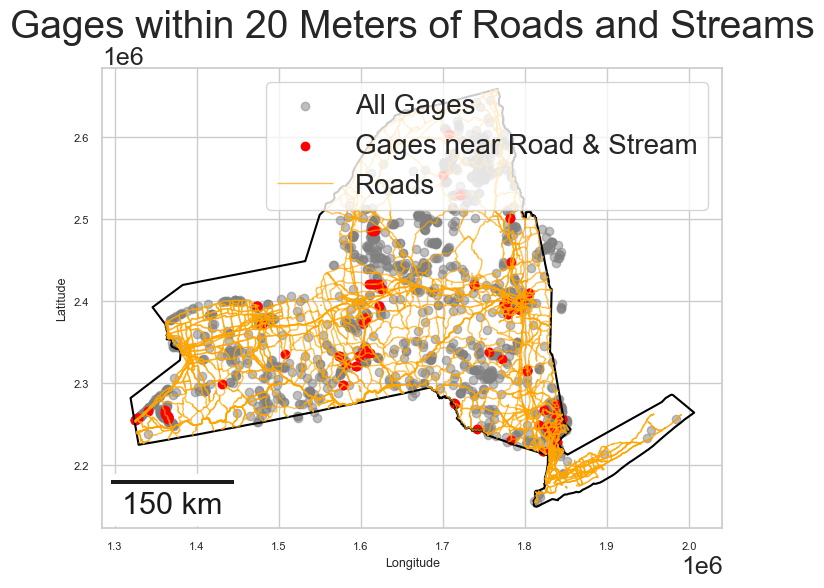

In [34]:
# Ensure all layers are in the same CRS
gages_geo.to_crs(epsg=5070, inplace=True)
road_shapefile.to_crs(epsg=5070, inplace=True)
stream_shapefile.to_crs(epsg=5070, inplace=True)

# Filter gages to include only those inside the state boundary
state_union = state_shapefile.geometry.unary_union
gages_in_state = gages_geo[gages_geo.intersects(state_union)]

# Create a 10-meter buffer around roads and streams
road_buffer = road_shapefile.buffer(20)
stream_buffer = stream_shapefile.buffer(20)

# Combine the buffers into one GeoDataFrame
road_buffer_gdf = gpd.GeoDataFrame(geometry=road_buffer)
stream_buffer_gdf = gpd.GeoDataFrame(geometry=stream_buffer)

# Find gages within 10 meters of roads
gages_near_road = gpd.sjoin(gages_in_state, road_buffer_gdf, how='inner', predicate='intersects')

# Find gages within 10 meters of streams
gages_near_stream = gpd.sjoin(gages_in_state, stream_buffer_gdf, how='inner', predicate='intersects')

# Find gages within 10 meters of both roads and streams
gages_near_both = gages_near_road[gages_near_road.index.isin(gages_near_stream.index)]

# Optionally, reset index if needed
gages_near_both.reset_index(drop=True, inplace=True)

# Plotting the selected gages
fig, ax = plt.subplots(figsize=(8, 8))
gages_geo.plot(ax=ax, color='gray', alpha=0.5, label='All Gages')  # Plot all gages
gages_near_both.plot(ax=ax, color='red', label='Gages near Road & Stream')  # Plot selected gages
road_shapefile.plot(ax=ax, color='orange', linewidth=1, alpha=0.7, label='Roads')
#stream_shapefile.plot(ax=ax, color='blue', linewidth=0.3, alpha=0.3, label='Streams')
state_shapefile.plot(ax=ax, edgecolor='black', linewidth=1.5, facecolor='none')

# Add scale bar
scalebar = ScaleBar(1, units="m", dimension="si-length", location="lower left")
ax.add_artist(scalebar)

ax.legend(fontsize=5, loc='upper left')
ax.set_title('Gages within 20 Meters of Roads and Streams', fontsize=5)
ax.set_xlabel('Longitude', fontsize=9)
ax.set_ylabel('Latitude', fontsize=9)
ax.tick_params(labelsize=8)


plt.legend()
plt.title('Gages within 20 Meters of Roads and Streams')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.savefig(r'D:\culvert repo\Results\Figures\USGS_stations_selected_for_validation.png', dpi=300)

plt.show()


In [32]:
#save the validation points
gages_near_both.to_file(r"D:\culvert repo\Results\Validation\watershed\validation_points.shp")

In [19]:
output_gage_dir = r'D:\hydrological analysis\data\Validation\waterhsed\clipped_points'
os.makedirs(output_gage_dir, exist_ok=True)

In [20]:
%%time
validation_huc=[]
for idx, row in HUC12_shapfile.iterrows():
    polygon = row['geometry']
    huc12 = row['huc12']
    # Create a GeoDataFrame for the current HUC12 region
    huc12_gdf = gpd.GeoDataFrame([row], columns=HUC12_shapfile.columns, crs=HUC12_shapfile.crs)

    # Clip the gages shapefile with the polygon
    clipped_culverts = gages_near_both[gages_near_both.intersects(polygon)]
    clipped_culverts = gpd.clip(clipped_culverts, polygon)
    if not clipped_culverts.empty:
        output_culvert_path = os.path.join(output_gage_dir, f'{huc12}_culverts.shp')
        
        # Remove duplicate BIN rows, keeping the first occurrence
        clipped_culverts = clipped_culverts.drop_duplicates(subset='BIN', keep='first')
        #
        clipped_culverts.to_file(output_culvert_path)
        validation_huc.append(huc12)
        
print(" validation points clipping and saving completed.")

<timed exec>:17: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'dec_long_va' to 'dec_long_v'
  ogr_write(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'coord_meth_cd' to 'coord_meth'
  ogr_write(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'coord_acy_cd' to 'coord_acy_'
  ogr_write(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'coord_datum_cd' to 'coord_datu'
  ogr_write(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'dec_coord_datum_cd' to 'dec_coord_'
  ogr_write(
C:\Users\Public\anac

 validation points clipping and saving completed.
CPU times: total: 1.33 s
Wall time: 4.35 s


<timed exec>:17: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'dec_long_va' to 'dec_long_v'
  ogr_write(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'coord_meth_cd' to 'coord_meth'
  ogr_write(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'coord_acy_cd' to 'coord_acy_'
  ogr_write(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'coord_datum_cd' to 'coord_datu'
  ogr_write(
C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'dec_coord_datum_cd' to 'dec_coord_'
  ogr_write(
C:\Users\Public\anac

In [21]:
len(validation_huc)

67

In [22]:
# Load the HUC12 list with all layers
with open(r"C:\hydrological analysis\data\HUC12 list with all layers\huc12_with_all_layers.txt", 'r') as file:
    huc12_all_layers = file.read().splitlines()

# Filter HUCs that are not in huc12_all_layers
filtered_hucs = [huc for huc in validation_huc if huc in huc12_all_layers ]
len(filtered_hucs)

63

In [23]:
###################################################delineat

In [24]:
#import libraries
import whitebox 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable 
from shapely.geometry import LineString
import os
import sys
from contextlib import contextmanager
import subprocess
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import rasterize
from rasterio.transform import from_origin
from watermark import watermark
import random
import py3dep
import pyproj
from pyproj import CRS
import shutil
import cProfile
from datetime import datetime
import requests
import os


In [25]:
# This function stops wbt from outputting text in the notebook
@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [26]:
%%time
#Define layers directories
output_huc12_dir = r'C:\hydrological analysis\data\Clipped layers\clipped_huc12'
output_stream_dir = r'D:\hydrological analysis\data\Clipped layers\clipped_streams'
output_road_dir = r'D:\hydrological analysis\data\Clipped layers\clipped_roads'
output_culvert_dir = r'D:\hydrological analysis\data\Validation\waterhsed\clipped_points'
output_DEM_dir=r'C:\hydrological analysis\data\HUC12_one meter_DEM'

CPU times: total: 0 ns
Wall time: 0 ns


In [27]:
%%time
selected_hucs=validation_huc

total_hucs = len(selected_hucs)
#total_hucs=1
# Print the list to verify
#print(selected_hucs)

CPU times: total: 0 ns
Wall time: 0 ns


In [28]:
%%time
# Define watershed delineation tool
wbt = whitebox.WhiteboxTools()


CPU times: total: 62.5 ms
Wall time: 310 ms


In [65]:
%%time
results = []
for i, huc in enumerate(selected_hucs):
#for huc in selected_hucs[0:1]:
    try:
        print(huc)
        # Print the HUC number and the percent of remaining HUCs in this chunk
        remaining_files = total_hucs - (i + 1)
        percent_remaining = (remaining_files / total_hucs) * 100
        print(f"HUC number: {huc}, Percent of remaining files: {percent_remaining:.2f}%")
        # path to the specific HUC layer
        output_huc12_path = os.path.join(output_huc12_dir, f'{huc}_huc12.shp')
        output_stream_path = os.path.join(output_stream_dir, f'{huc}_streams.shp')
        output_culvert_path = os.path.join(output_culvert_dir, f'{huc}_culverts.shp')
        output_road_path = os.path.join(output_road_dir, f'{huc}_roads.shp')
    
        # Load data using Geopandas
        huc12 = gpd.read_file(output_huc12_path)
        streams = gpd.read_file(output_stream_path)
        culverts = gpd.read_file(output_culvert_path)
        roads = gpd.read_file(output_road_path)
    
        #################################################################################################################################################
        # Define a bounding box over the HUC
        huc12 = huc12.to_crs(epsg=4326)
        minx, miny, maxx, maxy = huc12.bounds['minx'][0], huc12.bounds['miny'][0], huc12.bounds['maxx'][0], huc12.bounds['maxy'][0]
        
        url = 'https://portal.opentopography.org/API/usgsdem'
        params = {
            'datasetName': 'USGS1m',
            'south': miny,
            'north': maxy,
            'west': minx,
            'east': maxx,
            'outputFormat': 'GTiff',
            'API_Key': 'ac8c8a8ea7f3919e961e2fafc0da6b1a'
            #'API_Key': 'a1caf8e4f1c109e258a5eb732d3ff958'
            #'API_Key': 'a7b4d06ac31ca6e58eb38aef3fd1e717'
        }
        headers = {
            'accept': '*/*'
        }
        
        # Directory to save the downloaded DEMs
        directory = fr'C:\hydrological analysis\data\HUC12_one meter_DEM\{huc}'
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        # Function to download DEM
        def download_dem(west, east, filename):
            for attempt in range(3):
                params.update({'south': miny, 'north': maxy, 'west': west, 'east': east})
                response = requests.get(url, params=params, headers=headers)
                
                if response.status_code == 200:
                    file_path = f'{directory}/{filename}.tiff'
                    with open(file_path, 'wb') as f:
                        f.write(response.content)
                    print(f'File {filename} downloaded successfully and saved to {file_path}.')
                    return file_path
                elif response.status_code == 400:
                    print(f"400 Bad Request for {filename}. Splitting the bounding box and retrying.")
                    return None
                else:
                    print(f"Attempt {attempt + 1}: Failed to retrieve data - Status code: {response.status_code}")
                    if attempt < 2:
                        time.sleep(5)  # Wait for 5 seconds before retrying
                    else:
                        print(f"Failed to download {filename} after 3 attempts.")
                        return None
        
        # First attempt to download the DEM
        file_path = download_dem(minx, maxx, f'{huc}')
        
        # If 400 error occurs, download two DEMs by splitting the bounding box
        if file_path is None:
            midx = (minx + maxx) / 2
            
            file1 = download_dem(minx, midx+((maxx-minx)*0.1), f'{huc}_west')
            file2 = download_dem(midx-((maxx-minx)*0.1), maxx, f'{huc}_east')
            
            # Check if both files were downloaded successfully
            if file1 and file2:

                input_files = [
                    file1,
                    file2
                ]
                
                # Define output file paths
                output_mosaic = fr"C:\hydrological analysis\data\HUC12_one meter_DEM\{huc}\{huc}_10.tiff"
                reprojected_output = fr"C:\hydrological analysis\data\HUC12_one meter_DEM\{huc}\{huc}_reprojected_10.tiff"
                
                # Mosaic the input files
                vrt_options = gdal.BuildVRTOptions(resampleAlg='nearest')
                mosaic_vrt = gdal.BuildVRT('mosaic.vrt', input_files, options=vrt_options)
                
                # Check if the VRT was created successfully
                if mosaic_vrt is None:
                    raise ValueError("Failed to create the VRT mosaic.")
                
                # Convert the VRT to a GeoTIFF
                translated = gdal.Translate(output_mosaic, mosaic_vrt)
                if translated is None:
                    raise ValueError("Failed to translate the VRT to a GeoTIFF.")
                # Reproject the mosaic to the target CRS (NAD_1983_UTM)
                target_crs = 'EPSG:4326'  # Replace with the correct EPSG code for your UTM zone
                warp_options = gdal.WarpOptions(dstSRS=target_crs)
                warped = gdal.Warp(reprojected_output, output_mosaic, options=warp_options)
                file_path=reprojected_output
                if warped is None:
                    raise ValueError("Failed to reproject the mosaic.")
            else:
                print("Failed to download one or both of the DEMs, cannot proceed with mosaicing.")
            
        #################################################################################################################################################
        #reproject the temporary tiff from 4326 to 5070
        output_tiff=fr'C:\hydrological analysis\data\HUC12_one meter_DEM\{huc}\{huc}_5070.tiff'
        
        # Define source and target CRS
        src_crs = CRS.from_epsg(4326)  # Original CRS (EPSG:4326)
        dst_crs = CRS.from_epsg(5070)  # Target CRS (EPSG:5070)
        
        # Open the source raster
        with rasterio.open(file_path) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })
        
            # Reproject and save to the output file
            with rasterio.open(output_tiff, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest
                    )
        
        ##################################################################################################################################################
        # Clip and save the reprojected DEM
        clipped_tiff_dir = fr'C:\hydrological analysis\data\HUC12_one meter_DEM\{huc}'
        huc12 = huc12.to_crs(epsg=5070)
        # Ensure the directory exists
        if not os.path.exists(clipped_tiff_dir):
            os.makedirs(clipped_tiff_dir, exist_ok=True)
    
        clipped_tiff = os.path.join(clipped_tiff_dir, f'{huc}_DEM.tiff')
    
        # Convert the HUC12 boundary to GeoJSON-like format
        huc12_geom = [feature["geometry"] for feature in huc12.__geo_interface__["features"]]
    
        # Open the reprojected TIFF file and clip it using the HUC12 boundary
        with rasterio.open(output_tiff) as src:
            out_image, out_transform = mask(src, huc12_geom, crop=True)
        
            # Set NoData value
            out_image[out_image == src.nodata] = -99999
        
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
                "crs": src.crs,
                "nodata": -99999
            })
    
            # Save the clipped DEM to a new file
            with rasterio.open(clipped_tiff, 'w', **out_meta) as dst:
                dst.write(out_image)
        #################################################################################################################################################    
        # make a directory for watershed delineation analysis
        # Define and create the directory
        water_deal_dir_path=fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}'
        # Create the directory if it doesn't exist
        if not os.path.exists(water_deal_dir_path):
            os.makedirs(water_deal_dir_path)
    
        # Set the working directory
        wbt.set_working_dir(water_deal_dir_path)
        
        ###################################################################################################################################################
        # Lowers the elevation of roads to ground elevation (this helps to generate realistic stream flow that accounts for the existence of culverts)
        roadsburned_dem = fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{huc}_DEM_roadsburned_10.tif'
        with suppress_stdout():
            wbt.burn_streams_at_roads(
                clipped_tiff, 
                output_stream_path, 
                output_road_path, 
                roadsburned_dem, 
                width=60, 
            )
        ###############################################################################################################################################
        mo_dem_4 = fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{huc}_DEM_mo_4_10.tif'
        with suppress_stdout():
            wbt.fill_depressions(
                roadsburned_dem, 
                mo_dem_4, 
                fix_flats=True, 
                flat_increment=None, 
                max_depth=None, 
            )
        ###################################################################################################################################################
        # Generate Flow direction raster file
        flowdirection=  fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{huc}_flowdir_10.tif'
        with suppress_stdout():
            wbt.d8_pointer(
                mo_dem_4, 
                flowdirection, 
                esri_pntr=False, 
            )
        ###################################################################################################################################################
        # Generate Flow accumulation raster file
        flowacc=  fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{huc}flowacc_10.tif'
        with suppress_stdout():
            wbt.d8_flow_accumulation(
                mo_dem_4, 
                flowacc, 
                out_type="cells", 
                log=False, 
                clip=False, 
                pntr=False, 
                esri_pntr=False, 
            )
        ###################################################################################################################################################
        # Define the culvert_data, which will contain all information from this analysis
        culvert_data = []
        
        for index, row in culverts.iterrows():
            print(f'index: {index}')
            # Create a GeoDataFrame for the current row
            culvert = gpd.GeoDataFrame([row], geometry='geometry', crs=culverts.crs)
            
            # Transform CRS to EPSG:5070 and save as shapefile
            culvert = culvert.to_crs(epsg=5070)
            filename = f"{culvert['BIN'].iloc[0]}.shp"
            culvert_output_path = os.path.join(output_culvert_dir, filename)
            culvert.to_file(culvert_output_path)
            #
            sanppoints_path= fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{culvert["BIN"].iloc[0]}snap_pour_point_10.shp'
            with suppress_stdout():
                wbt.snap_pour_points(
                    culvert_output_path, 
                    flowacc, 
                    sanppoints_path, 
                    snap_dist=35, 
                )
            sanpped_points=gpd.read_file(sanppoints_path)
            sanpped_points = sanpped_points.set_crs(culverts.crs, allow_override=True)
    
            ###############################################################################################################################################
            # Watershed delineation based on snapped culvert points
    
            watershed=fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{culvert["BIN"].iloc[0]}watershed_10.tif'
            
            with suppress_stdout():
                wbt.watershed(
                    flowdirection, 
                    sanppoints_path, 
                    watershed, 
                    esri_pntr=False, 
                )
            # Path to the output vector file (Shapefile format)
            watershed_polygone = fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{culvert["BIN"].iloc[0]}watershed_poly_10.shp'
            with suppress_stdout():
                # Run the RasterToVectorPolygons tool
                wbt.raster_to_vector_polygons(watershed, watershed_polygone)
            ###############################################################################################################################################
            
            lfp=fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{huc}_lfp_10.shp'
            with suppress_stdout():
                wbt.longest_flowpath(
                    mo_dem_4, 
                    watershed, 
                    lfp, 
                )
            ###############################################################################################################################################
            #load the watershed and longest flow path data frames
            watershed_gdf=gpd.read_file(watershed_polygone)
            lfp_gdf=gpd.read_file(lfp)
            
            # Find the maximum flow path length and average slope
            max_length_rows = lfp_gdf.loc[lfp_gdf.groupby('BASIN')['LENGTH'].idxmax()]
            ################################################################################################################################################
            # Store all the data in the HUC_watersheds_info data frame
            culvert_data.append({
                'BIN': culvert["BIN"].iloc[0],
                "Ini_lon": culvert.to_crs(epsg=4326).geometry.x.values[0],
                "Ini_lat": culvert.to_crs(epsg=4326).geometry.y.values[0],
                'lon_snap': sanpped_points.to_crs(epsg=4326).geometry.x.values[0],
                'lat_snap': sanpped_points.to_crs(epsg=4326).geometry.y.values[0],
                'Area_m2': watershed_gdf.geometry.area.values[0],
                'Perimeter': watershed_gdf.geometry.length.values[0],
                'Length_LFP': max_length_rows['LENGTH'].values[0],
                'AVG_S_LFP': max_length_rows['AVG_SLOPE'].values[0],
                'geometry': watershed_gdf.geometry.values[0]
                })
            ##########################################################################################################################################
            usgs_area = culverts.drain_area[0]
        ################################################################################################################################################
        # List of file paths
        files_to_delete = [watershed, flowacc, flowdirection, mo_dem_4, roadsburned_dem, clipped_tiff, output_tiff]
        
        # Remove each file
        for file_path in files_to_delete:
            try:
                os.remove(file_path)
                print(f"{file_path} removed successfully.")
            except FileNotFoundError:
                print(f"{file_path} does not exist.")
            except PermissionError:
                print(f"You do not have permission to delete {file_path}.")
            except Exception as e:
                print(f"An error occurred with {file_path}: {e}")
        ############################################################################################################################################
        #Save all information about watersheds of the HUC in a shapefile
        # Create a data frame from the collected data
        culvert_df = pd.DataFrame(culvert_data)
        # Assuming culvert_df contains the data to be saved as a shapefile
        culvert_gdf = gpd.GeoDataFrame(culvert_df, geometry='geometry')
    
        # Check if CRS is set, and if not, assign it
        if culvert_gdf.crs is None:
            culvert_gdf.crs = CRS.from_epsg(5070)  # Replace with the appropriate EPSG cod
    
        # Path to save the shapefile
        final_HUC_path = fr'C:\hydrological analysis\data\waterhsed_delineation_dir\{huc}\{huc}_watersheds_info_10.shp'
    
        # Save the GeoDataFrame as a shapefile
        culvert_gdf.to_file(final_HUC_path)
        print(f"Shapefile saved to {final_HUC_path}")
        code_area = culvert_df.Area_m2[0] / (2.59 * 10**6)
        # Save the values to the results list
        results.append({'BIN':culvert["BIN"].iloc[0] ,'USGS_delineated_area': usgs_area, 'Delineated_area_by_code': code_area})
    
        print(f'USGS delineated area:{usgs_area}')
        print(f'Delineated area by code:{code_area}')
        #################################################################################################################################################
    except Exception as e:
        print(f"Failed to analyse HUC {huc}. Error: {e}")

011000060403
HUC number: 011000060403, Percent of remaining files: 98.51%
File 011000060403 downloaded successfully and saved to C:\hydrological analysis\data\HUC12_one meter_DEM\011000060403/011000060403.tiff.
index: 0
C:\hydrological analysis\data\waterhsed_delineation_dir\011000060403\01211310watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\011000060403\011000060403flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\011000060403\011000060403_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\011000060403\011000060403_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\011000060403\011000060403_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\011000060403\011000060403_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\011000060403\0110000604

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020200060402\01359810watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


C:\hydrological analysis\data\waterhsed_delineation_dir\020200060402\01359810watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060402\020200060402flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060402\020200060402_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060402\020200060402_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060402\020200060402_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020200060402\020200060402_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020200060402\020200060402_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020200060402\020200060402_watersheds_info_10.shp
USGS delineated area:0.62
Delineated area by code:0.494375702

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020200060204\0135932100watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


C:\hydrological analysis\data\waterhsed_delineation_dir\020200060204\0135932100watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060204\020200060204flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060204\020200060204_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060204\020200060204_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060204\020200060204_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020200060204\020200060204_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020200060204\020200060204_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020200060204\020200060204_watersheds_info_10.shp
USGS delineated area:1.79
Delineated area by code:2.1180995

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041300010104\0422028490watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


C:\hydrological analysis\data\waterhsed_delineation_dir\041300010104\0422028490watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041300010104\041300010104flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041300010104\041300010104_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041300010104\041300010104_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041300010104\041300010104_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\041300010104\041300010104_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\041300010104\041300010104_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041300010104\041300010104_watersheds_info_10.shp
USGS delineated area:1.52
Delineated area by code:1.3725210

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041403011203\04258165watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


C:\hydrological analysis\data\waterhsed_delineation_dir\041403011203\04258165watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041403011203\041403011203flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041403011203\041403011203_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041403011203\041403011203_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041403011203\041403011203_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\041403011203\041403011203_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\041403011203\041403011203_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041403011203\041403011203_watersheds_info_10.shp
USGS delineated area:1.94
Delineated area by code:2.458753559

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\043001040201\0427394005watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


C:\hydrological analysis\data\waterhsed_delineation_dir\043001040201\0427394005watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\043001040201\043001040201flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\043001040201\043001040201_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\043001040201\043001040201_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\043001040201\043001040201_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\043001040201\043001040201_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\043001040201\043001040201_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\043001040201\043001040201_watersheds_info_10.shp
USGS delineated area:1.27
Delineated area by code:36.416175

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041300030702\04231322watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


C:\hydrological analysis\data\waterhsed_delineation_dir\041300030702\04231322watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041300030702\041300030702flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041300030702\041300030702_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041300030702\041300030702_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041300030702\041300030702_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\041300030702\041300030702_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\041300030702\041300030702_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041300030702\041300030702_watersheds_info_10.shp
USGS delineated area:1.08
Delineated area by code:1.065764102

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041201010401\0421330790watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


index: 2
C:\hydrological analysis\data\waterhsed_delineation_dir\041201010401\0421330810watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041201010401\041201010401flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041201010401\041201010401_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041201010401\041201010401_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041201010401\041201010401_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\041201010401\041201010401_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\041201010401\041201010401_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041201010401\041201010401_watersheds_info_10.shp
USGS delineated area:0.28
Delineated area by code:

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020301010306\0137498290watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


C:\hydrological analysis\data\waterhsed_delineation_dir\020301010306\0137498290watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010306\020301010306flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010306\020301010306_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010306\020301010306_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010306\020301010306_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020301010306\020301010306_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020301010306\020301010306_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020301010306\020301010306_watersheds_info_10.shp
USGS delineated area:0.19
Delineated area by code:0.2031616

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020301010404\0137626925watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


index: 1


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020301010404\410304073564600watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


C:\hydrological analysis\data\waterhsed_delineation_dir\020301010404\410304073564600watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010404\020301010404flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010404\020301010404_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010404\020301010404_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010404\020301010404_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020301010404\020301010404_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020301010404\020301010404_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020301010404\020301010404_watersheds_info_10.shp
USGS delineated area:1.67
Delineated area by code:1.70

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020501020402\01509115watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


C:\hydrological analysis\data\waterhsed_delineation_dir\020501020402\01509115watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020501020402\020501020402flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020501020402\020501020402_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020501020402\020501020402_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020501020402\020501020402_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020501020402\020501020402_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020501020402\020501020402_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020501020402\020501020402_watersheds_info_10.shp
USGS delineated area:1.87
Delineated area by code:1.870336441

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020200060503\01361210watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


C:\hydrological analysis\data\waterhsed_delineation_dir\020200060503\01361210watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060503\020200060503flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060503\020200060503_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060503\020200060503_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060503\020200060503_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020200060503\020200060503_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020200060503\020200060503_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020200060503\020200060503_watersheds_info_10.shp
USGS delineated area:1.03
Delineated area by code:0.008345890

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020200080101\01372015watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


index: 1
C:\hydrological analysis\data\waterhsed_delineation_dir\020200080101\01372014watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200080101\020200080101flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200080101\020200080101_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200080101\020200080101_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200080101\020200080101_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020200080101\020200080101_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020200080101\020200080101_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020200080101\020200080101_watersheds_info_10.shp
USGS delineated area:0.57
Delineated area by code:0.

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020301010206\0137454960watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


C:\hydrological analysis\data\waterhsed_delineation_dir\020301010206\0137454960watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010206\020301010206flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010206\020301010206_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010206\020301010206_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010206\020301010206_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020301010206\020301010206_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020301010206\020301010206_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020301010206\020301010206_watersheds_info_10.shp
USGS delineated area:1.16
Delineated area by code:0.9233195

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020301010304\01374921watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


C:\hydrological analysis\data\waterhsed_delineation_dir\020301010304\01374921watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010304\020301010304flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010304\020301010304_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010304\020301010304_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010304\020301010304_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020301010304\020301010304_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020301010304\020301010304_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020301010304\020301010304_watersheds_info_10.shp
USGS delineated area:1.21
Delineated area by code:1.304036471

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020301010307\0137498960watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


index: 1
index: 2
index: 3
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010307\0137497690watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010307\020301010307flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010307\020301010307_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010307\020301010307_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020301010307\020301010307_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020301010307\020301010307_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020301010307\020301010307_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020301010307\020301010307_watersheds_info_10.shp
USGS delineated area:0.84
Deline

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020200060104\01358480watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


C:\hydrological analysis\data\waterhsed_delineation_dir\020200060104\01358480watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060104\020200060104flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060104\020200060104_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060104\020200060104_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060104\020200060104_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020200060104\020200060104_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020200060104\020200060104_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020200060104\020200060104_watersheds_info_10.shp
USGS delineated area:1.81
Delineated area by code:1.885220515

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020200060205\01359350watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


C:\hydrological analysis\data\waterhsed_delineation_dir\020200060205\01359350watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060205\020200060205flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060205\020200060205_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060205\020200060205_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060205\020200060205_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020200060205\020200060205_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020200060205\020200060205_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020200060205\020200060205_watersheds_info_10.shp
USGS delineated area:0.78
Delineated area by code:0.121562829

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020200060206\01359535watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


index: 2


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\020200060206\01359541watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


C:\hydrological analysis\data\waterhsed_delineation_dir\020200060206\01359541watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060206\020200060206flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060206\020200060206_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060206\020200060206_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\020200060206\020200060206_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020200060206\020200060206_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\020200060206\020200060206_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\020200060206\020200060206_watersheds_info_10.shp
USGS delineated area:1.5
Delineated area by code:1.5200943666

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402011009\04233283watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


index: 1
C:\hydrological analysis\data\waterhsed_delineation_dir\041402011009\04233281watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402011009\041402011009flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402011009\041402011009_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402011009\041402011009_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402011009\041402011009_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\041402011009\041402011009_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\041402011009\041402011009_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402011009\041402011009_watersheds_info_10.shp
USGS delineated area:1.4
Delineated area by code:0.0

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402020702\0424390405watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


C:\hydrological analysis\data\waterhsed_delineation_dir\041402020702\0424390405watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402020702\041402020702flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402020702\041402020702_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402020702\041402020702_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402020702\041402020702_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\041402020702\041402020702_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\041402020702\041402020702_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402020702\041402020702_watersheds_info_10.shp
USGS delineated area:1.12
Delineated area by code:24.719024

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402020703\0424393505watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


index: 1
C:\hydrological analysis\data\waterhsed_delineation_dir\041402020703\04243945watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402020703\041402020703flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402020703\041402020703_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402020703\041402020703_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402020703\041402020703_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\041402020703\041402020703_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\041402020703\041402020703_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402020703\041402020703_watersheds_info_10.shp
USGS delineated area:0.33
Delineated area by code:3.

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402020801\04243552watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


C:\hydrological analysis\data\waterhsed_delineation_dir\041402020801\04243552watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402020801\041402020801flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402020801\041402020801_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402020801\041402020801_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402020801\041402020801_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\041402020801\041402020801_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\041402020801\041402020801_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402020801\041402020801_watersheds_info_10.shp
USGS delineated area:1.35
Delineated area by code:1.444699961

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402020802\04243830watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


index: 1
index: 2


C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: C:\hydrological analysis\data\waterhsed_delineation_dir\041402020802\04243838watershed_poly_10.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


C:\hydrological analysis\data\waterhsed_delineation_dir\041402020802\04243838watershed_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402020802\041402020802flowacc_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402020802\041402020802_flowdir_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402020802\041402020802_DEM_mo_4_10.tif removed successfully.
C:\hydrological analysis\data\waterhsed_delineation_dir\041402020802\041402020802_DEM_roadsburned_10.tif removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\041402020802\041402020802_DEM.tiff removed successfully.
C:\hydrological analysis\data\HUC12_one meter_DEM\041402020802\041402020802_5070.tiff removed successfully.
Shapefile saved to C:\hydrological analysis\data\waterhsed_delineation_dir\041402020802\041402020802_watersheds_info_10.shp
USGS delineated area:1.22
Delineated area by code:1.063835062

In [115]:
df = pd.DataFrame(results)
# Relative error
df['Relative error'] = (abs(df['USGS_delineated_area'] - df['Delineated_area_by_code']) / df['USGS_delineated_area']) * 100
df = df.sort_values(by='Relative error', ascending=False)
# Save a .csv
output_path = r'D:\culvert repo\Results\Validation\watershed\validation_results.csv'
df.to_csv(output_path, index=False)\

In [4]:
df=pd.read_csv(r'D:\culvert repo\Results\Validation\watershed\validation_results.csv')

In [ ]:
# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Set Times New Roman font
plt.rcParams['font.family'] = 'Times New Roman'

# Melt the dataframe for easier plotting
df_melted = df.melt(id_vars='BIN', value_vars=['USGS_delineated_area', 'Delineated_area_by_code'],
                    var_name='Area Type', value_name='Area')

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='BIN', y='Area', hue='Area Type', data=df_melted)

# Customize the plot
plt.xticks(rotation=45)
plt.title('Comparison of USGS Delineated Area and Delineated Area by Code for each USGS station')
plt.xlabel('USGS site number')
plt.ylabel('Area (square mile)')

# Change legend labels
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['USGS', 'Scalable model']
plt.legend(handles, new_labels, title='Area delineated by')

plt.savefig(r'D:\hydrological analysis\data\Figures\watershedvalidationresults.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

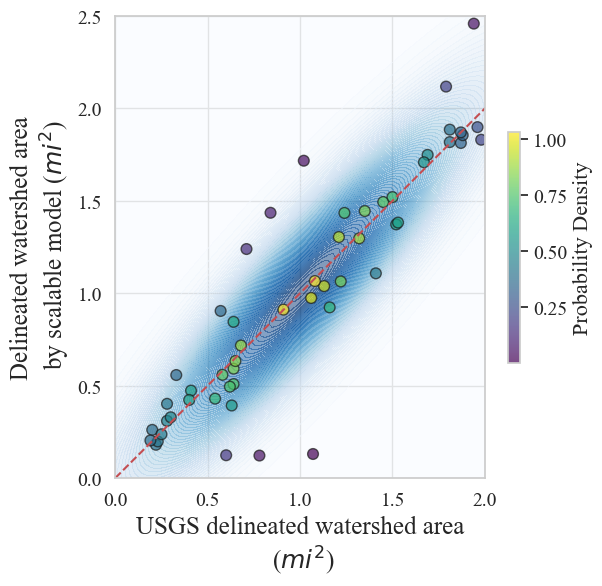

In [6]:
# Set style and font
sns.set(style="whitegrid")
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 16,              # Base font size
    'axes.titlesize': 18,         # Axis title size
    'axes.labelsize': 18,         # Axis label size
    'xtick.labelsize': 14,        # X tick label size
    'ytick.labelsize': 14,        # Y tick label size
    'legend.fontsize': 14,        # Legend font size
})

# Extract data
x = df['USGS_delineated_area']
y = df['Delineated_area_by_code']
data = np.vstack([x, y])

# Calculate mean and covariance for multivariate Gaussian
mean = data.mean(axis=1)
cov = np.cov(data)

# Fit the multivariate Gaussian and calculate density for each point
rv = multivariate_normal(mean, cov)
df['Probability'] = rv.pdf(data.T)  # Add probability density as a new column in df

# Create a grid of points over which to evaluate the Gaussian for background
xmin, xmax = 0, 2
ymin, ymax = 0, 2.5
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
pos = np.dstack((xx, yy))
pdf = rv.pdf(pos)

# Plot the Gaussian density as a background
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, pdf, levels=100, cmap="Blues", alpha=0.5)

# Overlay the scatter plot, coloring each point by its probability
scatter = plt.scatter(
    x=x, y=y,
    c=df['Probability'], cmap="viridis", s=60, edgecolor='k', alpha=0.7
)

# Customize the plot
plt.xlabel('USGS delineated watershed area\n ($mi^2$)')
plt.ylabel('Delineated watershed area\n by scalable model ($mi^2$)')

# Add a 45-degree line for reference
plt.plot([0, max(xmax, ymax)], [0, max(xmax, ymax)], 'r--')

# Set equal scaling
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.gca().set_aspect('equal', adjustable='box')

# Add a color bar for point probability
cbar = plt.colorbar(scatter, shrink=0.5)
cbar.set_label('Probability Density', fontsize=16)  # Label font size
cbar.ax.tick_params(labelsize=14)  # Tick label font size

# Save the plot
plt.savefig(r'D:\culvert repo\Results\Figures\watershedvalidationresults.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reset any Seaborn/rcParams changes
sns.reset_defaults()                 # undo seaborn overrides
plt.style.use('default')             # matplotlib default style
plt.rcParams.update(plt.rcParamsDefault)

# Now set ONLY what you want (to match the first plot)
plt.rcParams.update({
    'font.size': 10,
    # keep background plain white
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
})

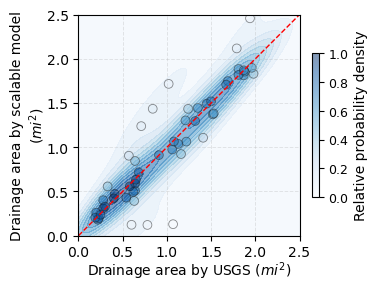

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# ------------------------
# Style (Matplotlib default, like your bar chart)
# ------------------------
plt.rcParams.update({
    'font.size': 10,
})

# ------------------------
# Data
# ------------------------
# Ensure numeric & drop NaNs/Infs
x = pd.to_numeric(df['USGS_delineated_area'], errors='coerce').to_numpy()
y = pd.to_numeric(df['Delineated_area_by_code'], errors='coerce').to_numpy()
valid = np.isfinite(x) & np.isfinite(y)
x, y = x[valid], y[valid]

# Limits
x_min, x_max = 0.0, 2.5
y_min, y_max = 0.0, 2.5

# ------------------------
# KDE fit
# ------------------------
kde = gaussian_kde([x, y])

dens = kde([x, y])
dens_norm = (dens - dens.min()) / (dens.max() - dens.min())

# ------------------------
# Figure
# ------------------------
fig, ax = plt.subplots(figsize=(3.88, 3.88))

# KDE background
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)
zz = kde([xx.ravel(), yy.ravel()]).reshape(xx.shape)

cs = ax.contourf(xx, yy, zz, levels=10, cmap='Blues', alpha=0.55)

# Scatter on top
sc = ax.scatter(
    x, y,
    c=dens_norm, cmap='Blues',
    s=40, edgecolor='k', linewidths=0.6, alpha=0.5
)

# Colorbar
cbar = fig.colorbar(sc, ax=ax, fraction=0.03, pad=0.05)
cbar.set_label('Relative probability density', fontsize=10)
cbar.ax.tick_params(labelsize=9)

# 1:1 reference line
lim = max(x_max, y_max)
ax.plot([0, lim], [0, lim], linestyle='--', linewidth=1.0, color='red')

# Labels, limits, ticks
ax.set_xlabel('Drainage area by USGS ($mi^2$)', fontsize=10, labelpad=0)
ax.set_ylabel('Drainage area by scalable model\n($mi^2$)', fontsize=10, labelpad=0)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal', adjustable='box')
ax.set_xticks(np.linspace(x_min, x_max, 6))
ax.set_yticks(np.linspace(y_min, y_max, 6))

# Grid (same as your bar chart)
ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7, alpha=0.3)
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, alpha=0.3)


plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\watershedvalidationresults_kde_scatter_matplotlib.png',
            dpi=300, bbox_inches='tight')
plt.show()

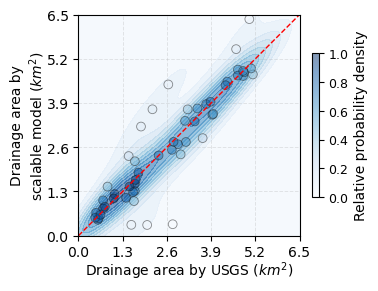

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# ------------------------
# Style
# ------------------------
plt.rcParams.update({
    'font.size': 10,
})

# ------------------------
# Data (convert mi² → km²)
# ------------------------
MI2_TO_KM2 = 2.58999

x = pd.to_numeric(df['USGS_delineated_area'], errors='coerce').to_numpy() * MI2_TO_KM2
y = pd.to_numeric(df['Delineated_area_by_code'], errors='coerce').to_numpy() * MI2_TO_KM2
valid = np.isfinite(x) & np.isfinite(y)
x, y = x[valid], y[valid]

# Limits (adjust for km² scale)
x_min, x_max = 0.0, 6.5   # since 2.5 mi² ≈ 6.5 km²
y_min, y_max = 0.0, 6.5

# ------------------------
# KDE fit
# ------------------------
kde = gaussian_kde([x, y])
dens = kde([x, y])
dens_norm = (dens - dens.min()) / (dens.max() - dens.min())

# ------------------------
# Figure
# ------------------------
fig, ax = plt.subplots(figsize=(3.88, 3.88))

# KDE background
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)
zz = kde([xx.ravel(), yy.ravel()]).reshape(xx.shape)

cs = ax.contourf(xx, yy, zz, levels=10, cmap='Blues', alpha=0.55)

# Scatter on top
sc = ax.scatter(
    x, y,
    c=dens_norm, cmap='Blues',
    s=40, edgecolor='k', linewidths=0.6, alpha=0.5
)

# Colorbar
cbar = fig.colorbar(sc, ax=ax, fraction=0.03, pad=0.05)
cbar.set_label('Relative probability density', fontsize=10)
cbar.ax.tick_params(labelsize=9)

# 1:1 reference line
lim = max(x_max, y_max)
ax.plot([0, lim], [0, lim], linestyle='--', linewidth=1.0, color='red')

# Labels, limits, ticks
ax.set_xlabel('Drainage area by USGS ($km^2$)', fontsize=10, labelpad=0)
ax.set_ylabel('Drainage area by\nscalable model ($km^2$)', fontsize=10, labelpad=0)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal', adjustable='box')
ax.set_xticks(np.linspace(x_min, x_max, 6))
ax.set_yticks(np.linspace(y_min, y_max, 6))

# Grid
ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7, alpha=0.3)
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, alpha=0.3)

plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\watershedvalidationresults_kde_scatter_km2.png',
            dpi=300, bbox_inches='tight')
plt.show()


In [76]:
# Error = scalable model - USGS
errors = y - x

# Bias (mean error), sample standard deviation, and MAE
avg_err = np.mean(errors)
std_err = np.std(errors, ddof=1)   # ddof=1 -> sample std
mae = np.mean(np.abs(errors))

print(f"Average error (y - x): {avg_err:.2f} km^2")
print(f"Standard deviation of error: {std_err:.2f} km^2")
print(f"Mean absolute error: {mae:.2f} km^2")

# (optional) keep the errors in your dataframe
df.loc[valid, 'error_km2'] = errors

from sklearn.metrics import r2_score

# --- R² calculation ---
r2 = r2_score(x, y)   # x = USGS, y = scalable model
print(f"R² = {r2:.2f}")


Average error (y - x): 0.00 km^2
Standard deviation of error: 0.69 km^2
Mean absolute error: 0.43 km^2
R² = 0.78
